# Reproducing Takao et al. paper: "Greatly mimics"

### Setup

In [4]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import gseapy as gp
from dotenv import load_dotenv
from scipy.stats import pearsonr, spearmanr, fisher_exact, ttest_ind

load_dotenv()

True

In [2]:
DATA_DIR = os.getenv("INFLAMM_DEBATE_FM_DATA_ROOT")
ANN_DATA_DIR = os.path.join(DATA_DIR, "processed/anndata_cleaned/")

# Load data
adatas = {}
for f in sorted(os.listdir(ANN_DATA_DIR)):
    if f.endswith(".h5ad"):
        name = f.replace(".h5ad", "")
        path = os.path.join(ANN_DATA_DIR, f)
        adatas[name] = ad.read_h5ad(path)
        print(f"Loaded {name}: {adatas[name].shape}")
adatas

Loaded human_burn: (590, 19914)
Loaded human_sepsis: (30, 19914)
Loaded human_trauma: (857, 19914)
Loaded mouse_burn: (32, 13832)
Loaded mouse_infection: (72, 10248)
Loaded mouse_sepsis: (50, 13832)
Loaded mouse_trauma: (96, 13832)


{'human_burn': AnnData object with n_obs × n_vars = 590 × 19914
     obs: 'group', 'patient_id', 'tissue', 'sex', 'age', 'time_point_hours', 'takao_inflamed', 'takao_control', 'takao_status', 'infl_acute', 'infl_subacute', 'infl_chronic'
     var: 'ensembl', 'symbol',
 'human_sepsis': AnnData object with n_obs × n_vars = 30 × 19914
     obs: 'tissue', 'group', 'takao_inflamed', 'takao_control', 'takao_status'
     var: 'ensembl', 'symbol',
 'human_trauma': AnnData object with n_obs × n_vars = 857 × 19914
     obs: 'group', 'patient_id', 'tissue', 'sex', 'age', 'time_point_hours', 'takao_inflamed', 'takao_control', 'takao_status', 'infl_acute', 'infl_subacute', 'infl_chronic'
     var: 'ensembl', 'symbol',
 'mouse_burn': AnnData object with n_obs × n_vars = 32 × 13832
     obs: 'title', 'cell_type', 'sex', 'strain', 'time_point_hours', 'group', 'patient_id', 'takao_inflamed', 'takao_control', 'takao_status', 'infl_acute', 'infl_subacute', 'infl_chronic'
     var: 'ensembl', 'symbol',
 '

### Differential expression

In [5]:
def takao_de_to_var(adata, fc_thresh=1.2, alpha=0.05):
    """
    Compute Takao-style differential expression and store results in adata.var.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object (samples x genes), assumed log2-normalized.
    fc_thresh : float, default=1.2
        Fold-change threshold (linear scale; Takao used 1.2 for mice, 2.0 for humans).
    alpha : float, default=0.05
        P-value threshold.

    Returns
    -------
    AnnData
        Same object with new columns in .var:
        - f"{prefix}_logfc" : mean log2 fold change
        - f"{prefix}_fc" : Takao-style linear fold change (signed with reciprocal transform)
        - f"{prefix}_pval" : t-test p-values
        - f"{prefix}_sig" : significance flag
    """
    inflamed_mask = adata.obs["takao_status"] == "takao_inflamed"
    control_mask  = adata.obs["takao_status"] == "takao_control"

    X = np.asarray(adata.X)
    inflamed = X[inflamed_mask, :]
    control  = X[control_mask, :]

    inflamed_mean = inflamed.mean(axis=0)
    control_mean  = control.mean(axis=0)

    # log2 fold change
    logfc = inflamed_mean - control_mean

    # convert back to linear fold change
    fc = 2 ** logfc

    # Takao transform
    takao_fc = np.where(fc >= 1, fc, -1.0 / (fc + 1e-8))

    # two-sample t-tests on log2 values (as NextBio likely did)
    t_res = ttest_ind(inflamed, control, axis=0, equal_var=False, nan_policy="omit")
    pvals = t_res.pvalue

    sig = (np.abs(takao_fc) > fc_thresh) & (pvals < alpha)

    adata.var["logfc"] = logfc
    adata.var["fc"]    = takao_fc
    adata.var["pval"]  = pvals
    adata.var["sig"]   = sig

    return adata

In [6]:
sig_adatas = {k: takao_de_to_var(v, fc_thresh=2.0, alpha=0.05) for k, v in adatas.items() if k in ["human_burn", "human_trauma", "human_sepsis"]}
sig_adatas = {**sig_adatas, **{k: takao_de_to_var(v, fc_thresh=1.2, alpha=0.05) for k, v in adatas.items() if k in ["mouse_burn", "mouse_trauma", "mouse_sepsis", "mouse_infection"]}}

### Figure 1

In [7]:
def compute_metrics(fc_x, fc_y):
    r, _ = pearsonr(fc_x, fc_y)
    r2 = r**2
    same_direction = (fc_x * fc_y > 0).sum()
    percent_same = same_direction / len(fc_x) * 100 if len(fc_x) > 0 else np.nan
    rho, _ = spearmanr(fc_x, fc_y)
    return {
        "R2_Pearson": r2,
        "Percent_Same_Direction": percent_same,
        "Spearman_rho": rho
    }

def plot_metrics_text(ax, metrics):
    text = (
        f"ρ = {metrics['Spearman_rho']:.2f}\n\n"
        f"%Dir = {metrics['Percent_Same_Direction']:.1f}\n"
        f"R² = {metrics['R2_Pearson']:.2f}"
    )
    ax.text(0.5, 0.5, text, ha="center", va="center", fontsize=24)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)

def plot_scatter_fc(ax, fc_x, fc_y):
    ax.scatter(fc_x, fc_y, s=10, alpha=0.6)
    lims = [min(fc_x.min(), fc_y.min()), max(fc_x.max(), fc_y.max())]
    ax.plot(lims, lims, color="red", lw=1)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    for spine in ax.spines.values():
        spine.set_visible(True)

def get_fc_vectors(dataset_i, dataset_j):
    """
    Return aligned Takao-style FC vectors for any pair of datasets.
    - Restricts to intersection of significant genes in both datasets.
    - All datasets are already mapped to human gene IDs (var_names).
    """
    adata_i, adata_j = dataset_i, dataset_j

    sig_i = set(adata_i.var_names[adata_i.var["sig"]])
    sig_j = set(adata_j.var_names[adata_j.var["sig"]])
    genes = list(sig_i & sig_j)

    if not genes:
        return np.array([]), np.array([]), 0

    return (
        adata_i.var.loc[genes, "fc"].astype(float).to_numpy(),
        adata_j.var.loc[genes, "fc"].astype(float).to_numpy(),
        len(genes)
    )

def make_comparison_grid(datasets_dict):
    """
    Create a comparison grid:
    - Diagonal: dataset names
    - Upper triangle: metrics
    - Lower triangle: scatter
    """
    dataset_names = list(datasets_dict.keys())
    dataset_names = [
        "human_burn",
        "human_trauma",
        "human_sepsis",
        "mouse_burn",
        "mouse_trauma",
        "mouse_sepsis",
        "mouse_infection",
    ]
    n = len(dataset_names)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))

    # Precompute FC vectors
    fc_vectors = {}
    for i, name_i in enumerate(dataset_names):
        for j, name_j in enumerate(dataset_names):
            if j < i:
                fc_vectors[(i, j)] = fc_vectors[(j, i)]
            else:
                vectors = get_fc_vectors(datasets_dict[name_i], datasets_dict[name_j])
                print(f"Computed FC vectors for {name_i} vs {name_j}, n={vectors[2]}")
                fc_vectors[(i, j)] = vectors

    # Diagonal: dataset names
    for i, name in enumerate(dataset_names):
        ax = axes[i, i]
        ax.text(0.5, 0.5, name.replace("_", " "), ha="center", va="center",
                fontsize=18, fontweight="bold")
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)

    # Upper triangle: metrics
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[i, j]
            fc_i, fc_j, n_genes = fc_vectors[(i, j)]
            if n_genes > 0:
                metrics = compute_metrics(fc_i, fc_j)
                plot_metrics_text(ax, metrics)
            else:
                ax.text(0.5, 0.5, "No overlap", ha="center", va="center")
            ax.set_xticks([]); ax.set_yticks([])

    # Lower triangle: scatter
    for i in range(1, n):
        for j in range(i):
            ax = axes[i, j]
            fc_i, fc_j, n_genes = fc_vectors[(i, j)]
            if n_genes > 0:
                plot_scatter_fc(ax, fc_i, fc_j)
            else:
                ax.text(0.5, 0.5, "No overlap", ha="center", va="center")
            ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    return fig


Computed FC vectors for human_burn vs human_burn, n=979
Computed FC vectors for human_burn vs human_trauma, n=641
Computed FC vectors for human_burn vs human_sepsis, n=473
Computed FC vectors for human_burn vs mouse_burn, n=277
Computed FC vectors for human_burn vs mouse_trauma, n=232
Computed FC vectors for human_burn vs mouse_sepsis, n=280
Computed FC vectors for human_burn vs mouse_infection, n=201
Computed FC vectors for human_trauma vs human_trauma, n=955
Computed FC vectors for human_trauma vs human_sepsis, n=306
Computed FC vectors for human_trauma vs mouse_burn, n=282
Computed FC vectors for human_trauma vs mouse_trauma, n=240
Computed FC vectors for human_trauma vs mouse_sepsis, n=259
Computed FC vectors for human_trauma vs mouse_infection, n=191
Computed FC vectors for human_sepsis vs human_sepsis, n=883
Computed FC vectors for human_sepsis vs mouse_burn, n=244
Computed FC vectors for human_sepsis vs mouse_trauma, n=256
Computed FC vectors for human_sepsis vs mouse_sepsis, n=

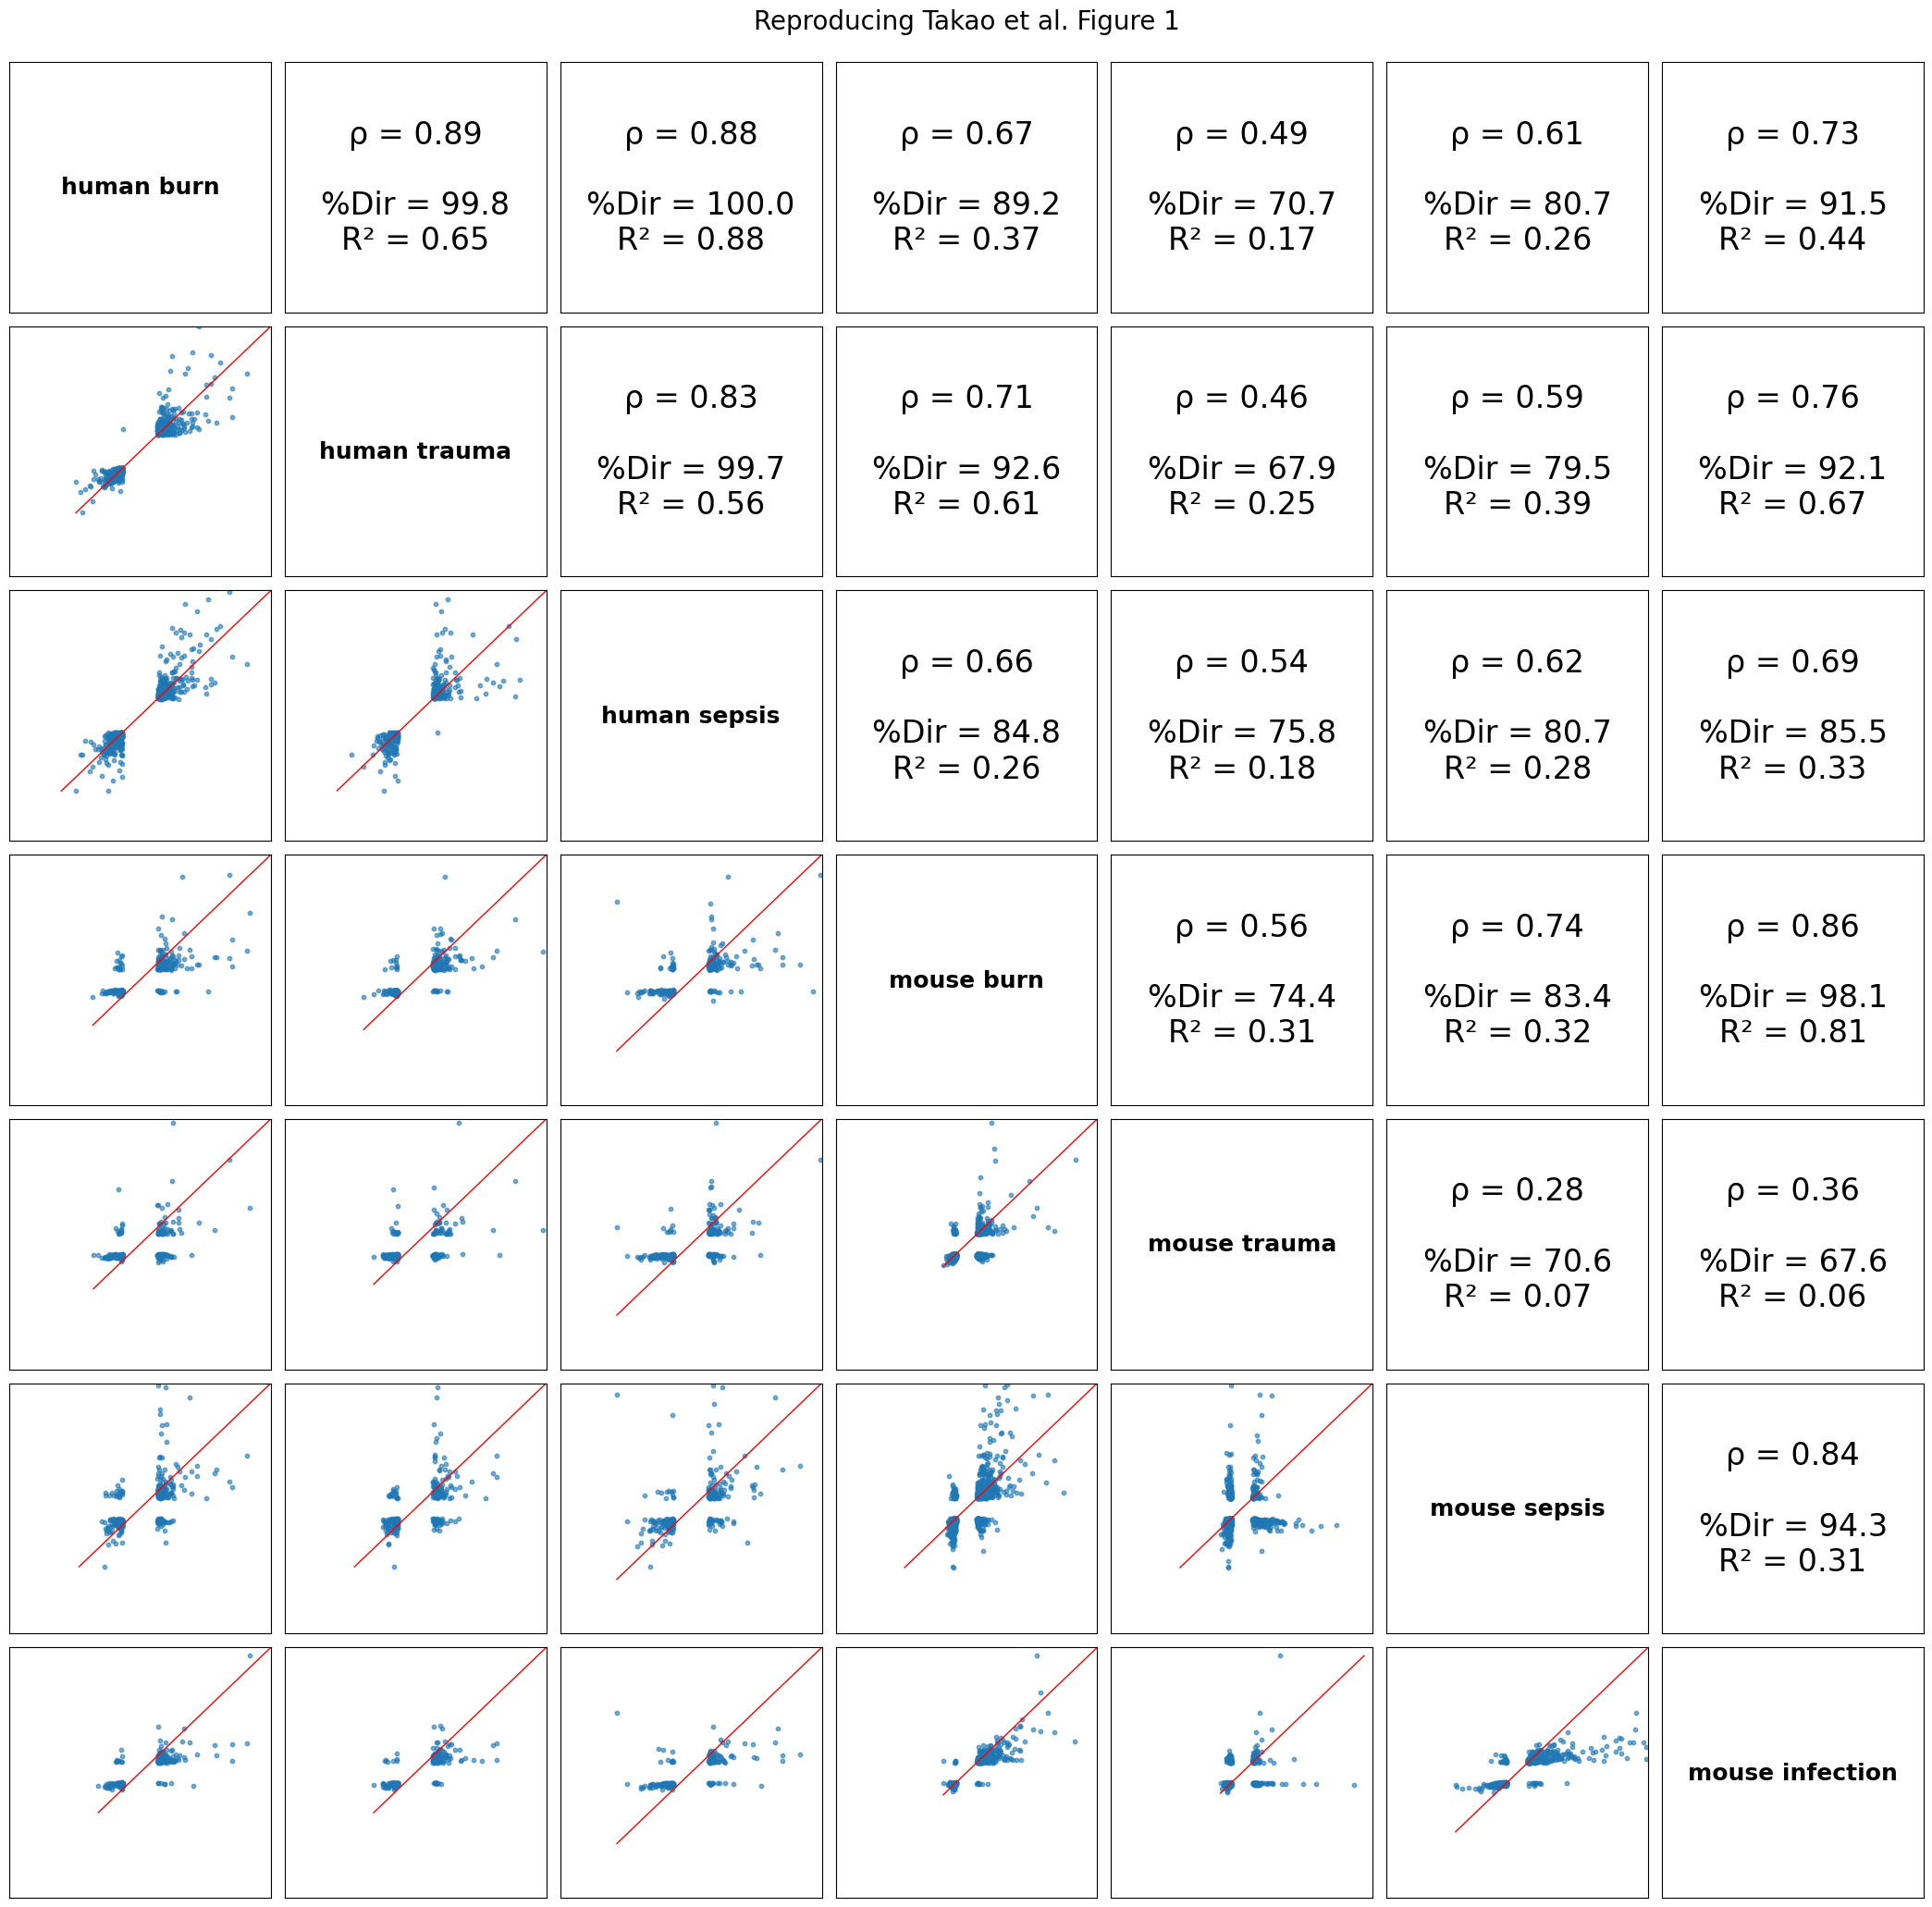

In [9]:
fig = make_comparison_grid(sig_adatas)
fig.suptitle("Reproducing Takao et al. Figure 1", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Figure 2

In [12]:
def overlap_fiveway(human_var, mouse_var, fc_thresh=1.2, p_thresh=0.05):
    """
    Compute 5 overlap tests between human and mouse DE gene sets:
    - Up-Up, Down-Down, Up-Down, Down-Up, Overall.
    Threshold: FC > 1.2 and p < 0.05 for both human and mouse.
    """
    # Human sets
    h_up   = set(human_var.query("fc > @fc_thresh and pval < @p_thresh").index)
    h_down = set(human_var.query("fc < -@fc_thresh and pval < @p_thresh").index)
    # Mouse sets
    m_up   = set(mouse_var.query("fc > @fc_thresh and pval < @p_thresh").index)
    m_down = set(mouse_var.query("fc < -@fc_thresh and pval < @p_thresh").index)

    universe = set(human_var.index) & set(mouse_var.index)

    def fisher(set1, set2):
        a = len(set1 & set2)
        b = len(set1 - set2)
        c = len(set2 - set1)
        d = len(universe - (set1 | set2))
        _, p = fisher_exact([[a, b],[c, d]], alternative="greater")
        return -np.log10(p) if p > 0 else np.inf, p, a

    results = {}
    results["Up-Up"]     = fisher(h_up, m_up)
    results["Down-Down"] = fisher(h_down, m_down)
    results["Up-Down"]   = fisher(h_up, m_down)
    results["Down-Up"]   = fisher(h_down, m_up)

    # --- Overall test (same vs opposite direction) ---
    common = (h_up | h_down) & (m_up | m_down)
    same = (h_up & m_up) | (h_down & m_down)
    diff = (h_up & m_down) | (h_down & m_up)

    a = len(same)
    b = len(diff)

    # For Fisher, need 2x2 table; compare against expectation ~50/50
    # Build background: all common genes
    d = len(universe) - (a+b)
    table = [[a, b], [b, d]]
    _, p = fisher_exact(table, alternative="greater")
    print(p)
    results["Overall"] = (-np.log10(p) if p > 0 else np.inf, p, a+b)

    return results

In [13]:
comparisons = {
    "Mouse Burn": sig_adatas["mouse_burn"].var,
    "Mouse Trauma": sig_adatas["mouse_trauma"].var,
    "Mouse Sepsis": sig_adatas["mouse_sepsis"].var,
    "Mouse Infection": sig_adatas["mouse_infection"].var,
}

# Collect results
all_results = {}
for label, mvar in comparisons.items():
    all_results[label] = overlap_fiveway(adatas["human_burn"].var, mvar)

# Tidy into dataframe
rows = []
for model, res in all_results.items():
    for combo, (score, p, n) in res.items():
        rows.append({
            "Model": model,
            "Combo": combo,
            "-log10p": score,
            "pval": p,
            "n": n
        })
df = pd.DataFrame(rows)
df

0.0
0.0
0.0
0.0


,Model,Combo,-log10p,pval,n
0,Mouse Burn,Up-Up,5.222387e+01,5.972123e-53,509
1,Mouse Burn,Down-Down,3.489948e+01,1.260441e-35,499
2,Mouse Burn,Up-Down,-0.000000e+00,1.000000e+00,81
3,Mouse Burn,Down-Up,-0.000000e+00,1.000000e+00,202
4,Mouse Burn,Overall,inf,0.000000e+00,1291
5,Mouse Trauma,Up-Up,9.036544e+00,9.192964e-10,263
6,Mouse Trauma,Down-Down,5.337254e+00,4.599873e-06,638
7,Mouse Trauma,Up-Down,2.340508e-03,9.946253e-01,366
8,Mouse Trauma,Down-Up,-0.000000e+00,1.000000e+00,138
9,Mouse Trauma,Overall,inf,0.000000e+00,1405


/tmp/ipykernel_1236410/4189025963.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, rotation=45, ha="right")
/tmp/ipykernel_1236410/4189025963.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, rotation=45, ha="right")
/tmp/ipykernel_1236410/4189025963.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, rotation=45, ha="right")
/tmp/ipykernel_1236410/4189025963.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, rotation=45, ha="right")


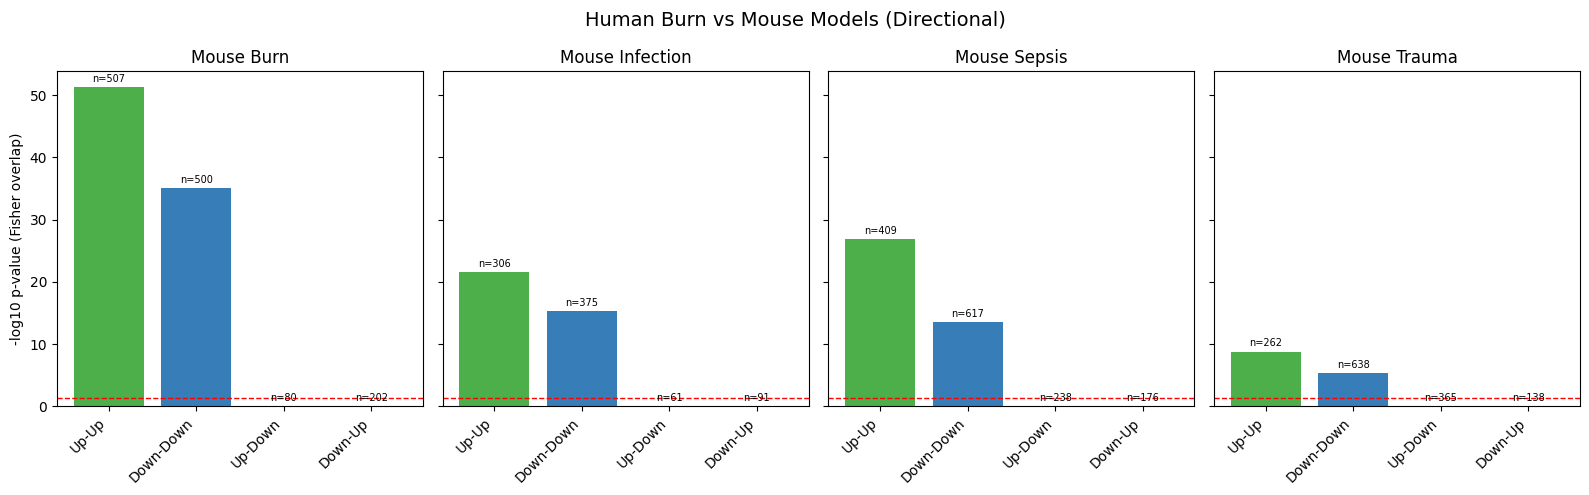

In [25]:
fig, axes = plt.subplots(1, len(comparisons), figsize=(16,5), sharey=True)

for ax, (model, subdf) in zip(axes, df.groupby("Model")):
    subdf = subdf.set_index("Combo").loc[["Up-Up","Down-Down","Up-Down","Down-Up"]]
    bars = ax.bar(subdf.index, subdf["-log10p"], color=["#4daf4a","#377eb8","#e41a1c","#984ea3"])
    ax.set_title(model)
    ax.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1)

    for rect, (_, row) in zip(bars, subdf.iterrows()):
        ax.text(rect.get_x()+rect.get_width()/2, rect.get_height()+0.5,
                f"n={row['n']}",
                ha="center", va="bottom", fontsize=7, rotation=0)

    ax.set_xticklabels(subdf.index, rotation=45, ha="right")

axes[0].set_ylabel("-log10 p-value (Fisher overlap)")
plt.suptitle("Human Burn vs Mouse Models (Directional)", fontsize=14)
plt.tight_layout()
plt.show()


### Figure 3

In [14]:
def compute_similarity(human_var, mouse_var, 
                       human_fc_thresh=2.0, mouse_fc_thresh=1.25, p_thresh=0.05):
    """
    Compute Pearson R and % same direction between human and mouse DE genes.
    Thresholds can be varied to mimic Takao Fig. 3 conditions.
    """  
    human_sig = human_var.query("abs(fc) > @human_fc_thresh and pval < @p_thresh")

    if mouse_fc_thresh > 0:
        mouse_sig = mouse_var.query("abs(fc) > @mouse_fc_thresh and pval < @p_thresh")
    else:
        mouse_sig = mouse_var  # all genes

    common = human_sig.index.intersection(mouse_sig.index)
    if len(common) == 0:
        return np.nan, np.nan, 0
    
    fc_h = human_var.loc[common, "logfc"]
    fc_m = mouse_var.loc[common, "logfc"]

    # Pearson correlation
    r, pval = pearsonr(fc_h, fc_m)
    
    # % same direction
    same = (np.sign(fc_h) == np.sign(fc_m)).mean() * 100
    
    return r, pval, same, len(common)


In [15]:
comparisons = {
    "Mouse Burn": sig_adatas["mouse_burn"].var,
    "Mouse Trauma": sig_adatas["mouse_trauma"].var,
    "Mouse Sepsis": sig_adatas["mouse_sepsis"].var,
    "Mouse Infection": sig_adatas["mouse_infection"].var,
}


results = []

# --- Human vs Mouse (red hollow: H2/M1.2)
for model, mvar in comparisons.items():
    r, pval, same, n = compute_similarity(sig_adatas['human_burn'].var, mvar, 2.0, 1.2)
    results.append({"Model": model, "R": r, "pval": pval, "%Same": same, "N": n,
                    "Symbol": "circle", "Color": "red", "Fill": "none", "Thresh": "H2/M1.2"})

# --- Human vs Mouse (red filled: H4/M1.2)
for model, mvar in comparisons.items():
    r, pval, same, n = compute_similarity(sig_adatas['human_burn'].var, mvar, 4.0, 1.2)
    results.append({"Model": model, "R": r, "pval": pval, "%Same": same, "N": n,
                    "Symbol": "circle", "Color": "red", "Fill": "full", "Thresh": "H4/M1.2"})

# --- Human vs Human (blue filled circles)
for label, other in {"Trauma": sig_adatas['human_trauma'].var, "Sepsis": sig_adatas['human_sepsis'].var}.items():
    r, pval, same, n = compute_similarity(sig_adatas['human_burn'].var, other, 2.0, 0.0)
    results.append({"Model": f"Human Burn vs {label}", "R": r, "pval": pval, "%Same": same, "N": n,
                    "Symbol": "square", "Color": "blue", "Fill": "full", "Thresh": "Human-Human"})

# --- Human vs Mouse (blue hollow squares: H2/Mall)
for model, mvar in comparisons.items():
    r, pval, same, n = compute_similarity(sig_adatas['human_burn'].var, mvar, 2.0, 0.0)
    results.append({"Model": model, "R": r, "pval": pval, "%Same": same, "N": n,
                    "Symbol": "circle", "Color": "blue", "Fill": "full", "Thresh": "H2/Mall"})

df = pd.DataFrame(results)
df

,Model,R,pval,%Same,N,Symbol,Color,Fill,Thresh
0,Mouse Burn,0.729558,2.777889e-47,89.169675,277,circle,red,none,H2/M1.2
1,Mouse Trauma,0.461062,1.300253e-13,70.689655,232,circle,red,none,H2/M1.2
2,Mouse Sepsis,0.656710,6.198118e-36,80.714286,280,circle,red,none,H2/M1.2
3,Mouse Infection,0.785925,2.027727e-43,91.542289,201,circle,red,none,H2/M1.2
4,Mouse Burn,0.659135,3.028288e-05,90.909091,33,circle,red,full,H4/M1.2
5,Mouse Trauma,0.629251,6.802340e-03,88.235294,17,circle,red,full,H4/M1.2
6,Mouse Sepsis,0.702866,4.346873e-05,100.000000,27,circle,red,full,H4/M1.2
7,Mouse Infection,0.694295,3.373754e-04,95.454545,22,circle,red,full,H4/M1.2
8,Human Burn vs Trauma,0.924152,0.000000e+00,98.876404,979,square,blue,full,Human-Human
9,Human Burn vs Sepsis,0.897150,0.000000e+00,96.731359,979,square,blue,full,Human-Human


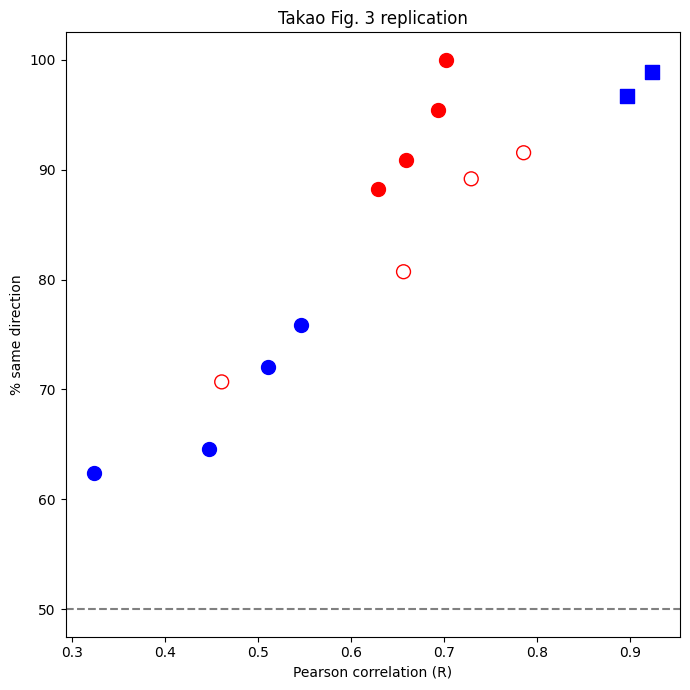

In [16]:
fig, ax = plt.subplots(figsize=(7,7))

for _, row in df.iterrows():
    marker = "o" if row["Symbol"] == "circle" else "s"
    edge = row["Color"]
    face = edge if row["Fill"] == "full" else "none"

    ax.scatter(row["R"], row["%Same"],
               marker=marker, edgecolor=edge, facecolor=face, s=100,
               label=f"{row['Model']} ({row['Thresh']})")

# Chance baseline
ax.axhline(50, color="gray", linestyle="--")

ax.set_xlabel("Pearson correlation (R)")
ax.set_ylabel("% same direction")
ax.set_title("Takao Fig. 3 replication")

# Deduplicate legend

plt.tight_layout()
plt.show()


### Figure 4

In [17]:
# get gene sets
gene_set_names = [
    "innate immune response (GO:0045087)",
    "Cytokine Signaling in Immune System",
    "lymphocyte differentiation (GO:0030098)",
    "Translocation of ZAP-70 to Immunological Synapse"
]

gene_set_go = gp.get_library(name="GO_Biological_Process_2021", organism="Human")
gene_set_msigdb = gp.get_library(name="Reactome_Pathways_2024", organism="Human")

In [18]:
# get the gene set by searching for key in both dictionaries
def get_gene_set(key, gene_set_dicts):
    for gene_set_dict in gene_set_dicts:
        # try indexing by key until found
        if key in gene_set_dict:
            return gene_set_dict[key]

    return []

gene_sets = {name: get_gene_set(name, [gene_set_go, gene_set_msigdb]) for name in gene_set_names}

In [19]:
def get_de_sets(var, fc_thresh=1.2, p_thresh=0.05):
    de_up = set(var.query("fc > @fc_thresh and pval < @p_thresh")["symbol"])
    de_down = set(var.query("fc < -@fc_thresh and pval < @p_thresh")["symbol"])
    return de_up, de_down

def pathway_enrichment_split(de_up, de_down, background, gene_sets):
    """Fisher enrichment for each pathway, split into activated/suppressed."""
    results = []
    for pathway, genes in gene_sets.items():
        geneset = set(genes) & background
        for label, deg in [("activated", de_up), ("suppressed", de_down)]:
            a = len(deg & geneset)
            b = len(deg - geneset)
            c = len(geneset - deg)
            d = len(background - (deg | geneset))
            if (a+b) > 0 and (c+d) > 0:
                _, p = fisher_exact([[a,b],[c,d]], alternative="greater")
                score = -np.log10(p) if p > 0 else np.inf
            else:
                p, score, a = 1.0, 0, 0
            # flip sign if suppressed
            if label == "suppressed":
                score = -score
            results.append({
                "Pathway": pathway,
                "Direction": label,
                "Score": score,
                "pval": p,
                "n": a
            })
    return results


In [20]:
# Restrict background to genes with expression info in human burn
background = set(sig_adatas['human_burn'].var["symbol"])

rows = []
for label, adata in sig_adatas.items():
    var = adata.var
    de_up, de_down = get_de_sets(var)
    res = pathway_enrichment_split(de_up, de_down, background, gene_sets)
    for r in res:
        r["Dataset"] = label
        rows.append(r)

df = pd.DataFrame(rows)
df

,Pathway,Direction,Score,pval,n,Dataset
0,innate immune response (GO:0045087),activated,11.226106,5.941471e-12,76,human_burn
1,innate immune response (GO:0045087),suppressed,-0.067323,8.564006e-01,42,human_burn
2,Cytokine Signaling in Immune System,activated,20.538451,2.894335e-21,190,human_burn
3,Cytokine Signaling in Immune System,suppressed,-2.360352,4.361617e-03,163,human_burn
4,lymphocyte differentiation (GO:0030098),activated,0.815639,1.528835e-01,14,human_burn
5,lymphocyte differentiation (GO:0030098),suppressed,-1.348349,4.483851e-02,21,human_burn
6,Translocation of ZAP-70 to Immunological Synapse,activated,0.032630,9.276203e-01,1,human_burn
7,Translocation of ZAP-70 to Immunological Synapse,suppressed,-8.560211,2.752888e-09,15,human_burn
8,innate immune response (GO:0045087),activated,7.570718,2.687086e-08,55,human_sepsis
9,innate immune response (GO:0045087),suppressed,-0.727985,1.870745e-01,43,human_sepsis


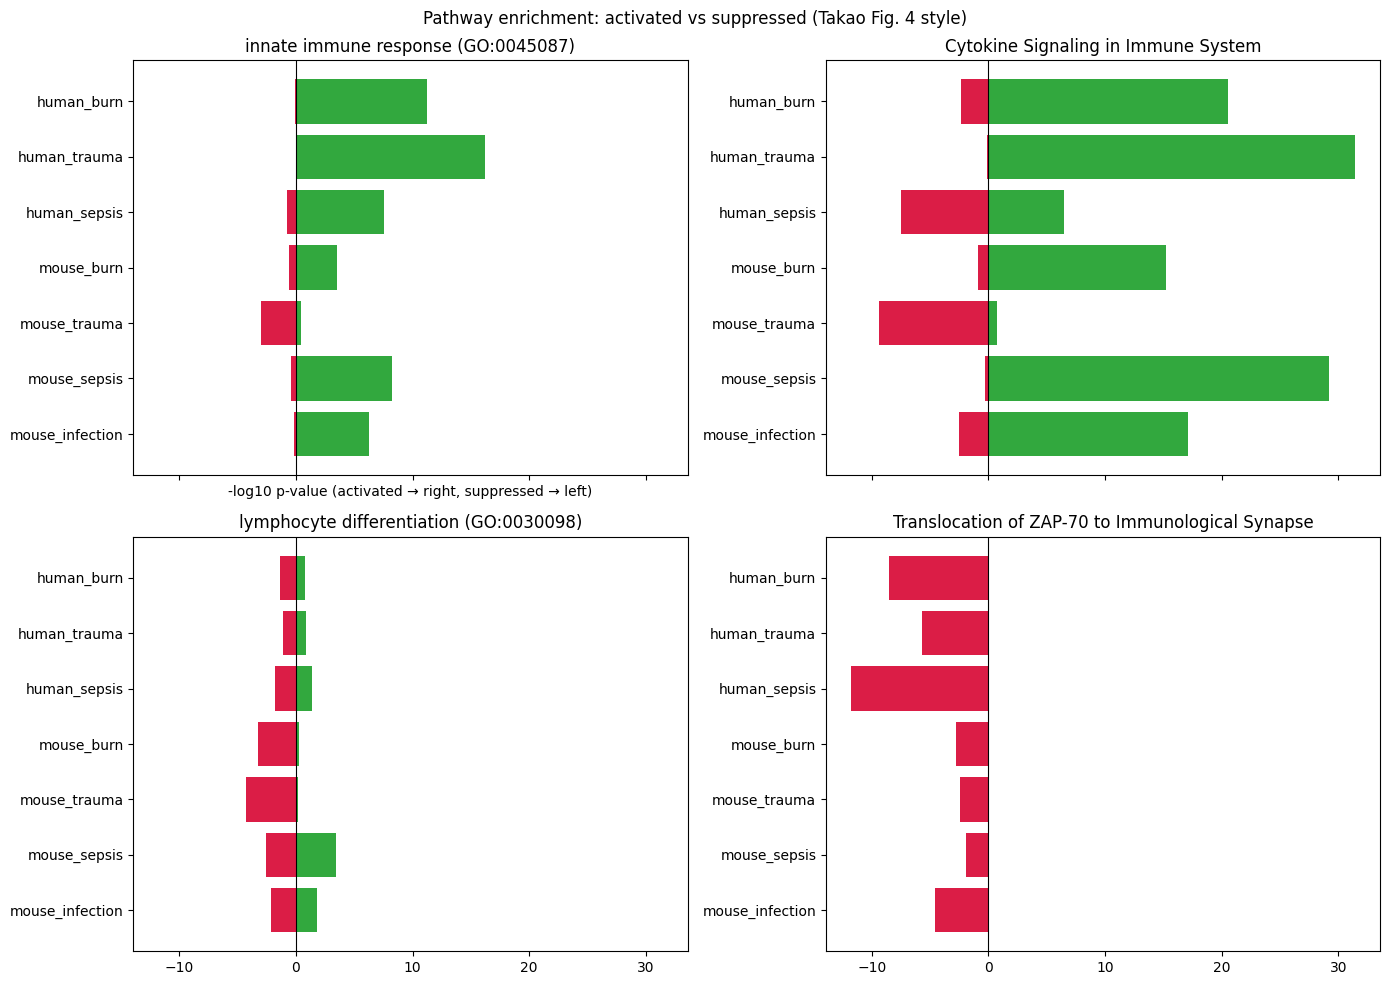

In [21]:
dataset_order = [
    "human_burn",
    "human_trauma",
    "human_sepsis",
    "mouse_burn",
    "mouse_trauma",
    "mouse_sepsis",
    "mouse_infection",
]

fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)

order = list(sig_adatas.keys())
pathways = list(gene_sets.keys())
axes = axes.flatten()

colors = {"activated":"#32a83e", "suppressed":"#db1d46"}

for ax, pw in zip(axes, pathways):
    sub = df[df["Pathway"] == pw]
    
    # Keep datasets in consistent order
    for i, dataset in enumerate(dataset_order[::-1]):
        row_up = sub[(sub["Dataset"] == dataset) & (sub["Direction"] == "activated")]
        row_down = sub[(sub["Dataset"] == dataset) & (sub["Direction"] == "suppressed")]
        
        # Draw horizontal bars
        ax.barh(dataset, row_up["Score"], color=colors["activated"])
        ax.barh(dataset, row_down["Score"], color=colors["suppressed"])
    
    ax.set_title(pw)
    ax.axvline(0, color="black", linewidth=0.8)

axes[0].set_xlabel("-log10 p-value (activated → right, suppressed → left)")
plt.suptitle("Pathway enrichment: activated vs suppressed (Takao Fig. 4 style)")
plt.tight_layout()
plt.show()